## Analyzing Neighborhoods in Mumbai to Start a new Restaurant

### Importing required libraries

In [1]:
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: Cryptograp

### Data Retrieval

In [41]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai')[-1]
df.rename(columns={'Area': 'Neighborhood'}, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
5,Marol,"Andheri,Western Suburbs",19.119219,72.882743
6,Sahar,"Andheri,Western Suburbs",19.098889,72.867222
7,Seven Bungalows,"Andheri,Western Suburbs",19.129052,72.817018
8,Versova,"Andheri,Western Suburbs",19.120000,72.820000
9,Mira Road,"Mira-Bhayandar,Western Suburbs",19.284167,72.871111


### Data Wrangling

In [42]:
df['Location'].value_counts()

South Mumbai                       30
Andheri,Western Suburbs             8
Western Suburbs                     6
Eastern Suburbs                     4
Mira-Bhayandar,Western Suburbs      3
Bandra,Western Suburbs              3
Powai,Eastern Suburbs               3
Ghatkopar,Eastern Suburbs           3
Kandivali West,Western Suburbs      3
Vasai,Western Suburbs               2
Borivali (West),Western Suburbs     2
Kalbadevi,South Mumbai              2
Harbour Suburbs                     2
Khar,Western Suburbs                2
Malad,Western Suburbs               2
Goregaon,Western Suburbs            2
Mumbai                              2
Govandi,Harbour Suburbs             1
Byculla,South Mumbai                1
Fort,South Mumbai                   1
Antop Hill,South Mumbai             1
Colaba,South Mumbai                 1
Kamathipura,South Mumbai            1
Sanctacruz,Western Suburbs          1
Mulund,Eastern Suburbs              1
Trombay,Harbour Suburbs             1
Dadar,South 

We can see that there are many locations that appear only once or twice. This is because the main locations like "Western Suburbs" or "South Mumbai" are being further divided by the area within these locations. Lets clean the Location column to make it easier to understand.

In [43]:
df['Location'] = df['Location'].apply(lambda x: x.split(',')[-1])
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270
5,Marol,Western Suburbs,19.119219,72.882743
6,Sahar,Western Suburbs,19.098889,72.867222
7,Seven Bungalows,Western Suburbs,19.129052,72.817018
8,Versova,Western Suburbs,19.120000,72.820000
9,Mira Road,Western Suburbs,19.284167,72.871111


In [44]:
df['Location'].value_counts()

South Mumbai       39
Western Suburbs    36
Eastern Suburbs    12
Harbour Suburbs     4
Mumbai              2
Name: Location, dtype: int64

In [45]:
df

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270
...,...,...,...,...
88,Parel,South Mumbai,18.990000,72.840000
89,Gowalia Tank,South Mumbai,18.962450,72.809703
90,Dava Bazaar,South Mumbai,18.946882,72.831362
91,Dharavi,Mumbai,19.040208,72.850850


Although the data we gathered contained latitude and longitude information, we can reconfirm these coordinates using Geocoder.



In [47]:
df['Latitude1'] = None
df['Longitude1'] = None

for i, neigh in enumerate(df['Neighborhood']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Mumbai, India'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude1'] = latitude
    df.loc[i, 'Longitude1'] = longitude

df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1
0,Amboli,Western Suburbs,19.129300,72.843400,19.1291,72.8464
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,19.1084,72.8623
2,D.N. Nagar,Western Suburbs,19.124085,72.831373,19.1251,72.8325
3,Four Bungalows,Western Suburbs,19.124714,72.827210,19.1264,72.8242
4,Lokhandwala,Western Suburbs,19.130815,72.829270,19.1432,72.8249
5,Marol,Western Suburbs,19.119219,72.882743,19.1191,72.8828
6,Sahar,Western Suburbs,19.098889,72.867222,19.1027,72.8626
7,Seven Bungalows,Western Suburbs,19.129052,72.817018,19.1286,72.8212
8,Versova,Western Suburbs,19.120000,72.820000,19.1377,72.8135
9,Mira Road,Western Suburbs,19.284167,72.871111,19.2656,72.8706



We can create new columns to see the difference between coordinate values obtained from wikipedia and those obtained from geocoder. We will take the absolute difference between these values and store them in our dataframe.

In [48]:
df['Latdiff'] = abs(df['Latitude'] - df['Latitude1'])
df['Longdiff'] = abs(df['Longitude'] - df['Longitude1'])
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.129300,72.843400,19.1291,72.8464,0.00024,0.00304
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,19.1084,72.8623,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.124085,72.831373,19.1251,72.8325,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.124714,72.827210,19.1264,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.130815,72.829270,19.1432,72.8249,0.012345,0.0044
5,Marol,Western Suburbs,19.119219,72.882743,19.1191,72.8828,0.000169,6.7e-05
6,Sahar,Western Suburbs,19.098889,72.867222,19.1027,72.8626,0.00377822,0.00462255
7,Seven Bungalows,Western Suburbs,19.129052,72.817018,19.1286,72.8212,0.000492,0.004162
8,Versova,Western Suburbs,19.120000,72.820000,19.1377,72.8135,0.01769,0.00652
9,Mira Road,Western Suburbs,19.284167,72.871111,19.2656,72.8706,0.0185438,0.000467611


We can see that the latitude and longitudes from wikipedia and geocoder are very similar, yet there are some differences. We will replace the values with the coordinates obtained from geocoder if the absolute difference is more than 0.001.

In [49]:
df.loc[df.Latdiff>0.001, 'Latitude'] = df.loc[df.Latdiff>0.001, 'Latitude1']
df.loc[df.Longdiff>0.001, 'Longitude'] = df.loc[df.Longdiff>0.001, 'Longitude1']
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.8464,19.1291,72.8464,0.00024,0.00304
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,19.1251,72.8325,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249,0.012345,0.0044
5,Marol,Western Suburbs,19.1192,72.8827,19.1191,72.8828,0.000169,6.7e-05
6,Sahar,Western Suburbs,19.1027,72.8626,19.1027,72.8626,0.00377822,0.00462255
7,Seven Bungalows,Western Suburbs,19.1291,72.8212,19.1286,72.8212,0.000492,0.004162
8,Versova,Western Suburbs,19.1377,72.8135,19.1377,72.8135,0.01769,0.00652
9,Mira Road,Western Suburbs,19.2656,72.8711,19.2656,72.8706,0.0185438,0.000467611


In order to confirm if values have actually been replaced we can use the where method. Values with NaN means those values have not been replaced.



In [50]:
df.where(df['Latitude']==df['Latitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623,0.003028,0.001497
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249,0.012345,0.0044
...,...,...,...,...,...,...,...,...
88,Parel,South Mumbai,18.9957,72.84,18.9957,72.8391,0.0057,0.00087
89,Gowalia Tank,South Mumbai,18.9645,72.8112,18.9645,72.8112,0.00201,0.001467
90,Dava Bazaar,South Mumbai,19.1314,72.927,19.1314,72.927,0.184518,0.095598
91,Dharavi,Mumbai,19.0467,72.8546,19.0467,72.8546,0.006532,0.00376


We can do the same for the Longitude column.



In [51]:
df.where(df['Longitude']==df['Longitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.8464,19.1291,72.8464,0.00024,0.00304
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,19.1251,72.8325,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249,0.012345,0.0044
...,...,...,...,...,...,...,...,...
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,Gowalia Tank,South Mumbai,18.9645,72.8112,18.9645,72.8112,0.00201,0.001467
90,Dava Bazaar,South Mumbai,19.1314,72.927,19.1314,72.927,0.184518,0.095598
91,Dharavi,Mumbai,19.0467,72.8546,19.0467,72.8546,0.006532,0.00376


Now that we have the data, we can drop the columns that are no longer useful.



In [52]:
df.drop(['Latitude1', 'Longitude1', 'Latdiff', 'Longdiff'], axis=1, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.1293,72.8464
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623
2,D.N. Nagar,Western Suburbs,19.1241,72.8325
3,Four Bungalows,Western Suburbs,19.1264,72.8242
4,Lokhandwala,Western Suburbs,19.1432,72.8249
5,Marol,Western Suburbs,19.1192,72.8827
6,Sahar,Western Suburbs,19.1027,72.8626
7,Seven Bungalows,Western Suburbs,19.1291,72.8212
8,Versova,Western Suburbs,19.1377,72.8135
9,Mira Road,Western Suburbs,19.2656,72.8711


### Data Visualization

To understand our data better, we can see how many neighborhoods are in each location.

In [53]:
neighborhoods_mumbai = df.groupby('Location')['Neighborhood'].nunique()
neighborhoods_mumbai

Location
Eastern Suburbs    12
Harbour Suburbs     4
Mumbai              2
South Mumbai       39
Western Suburbs    36
Name: Neighborhood, dtype: int64

We can now plot this data.

<IPython.core.display.Javascript object>


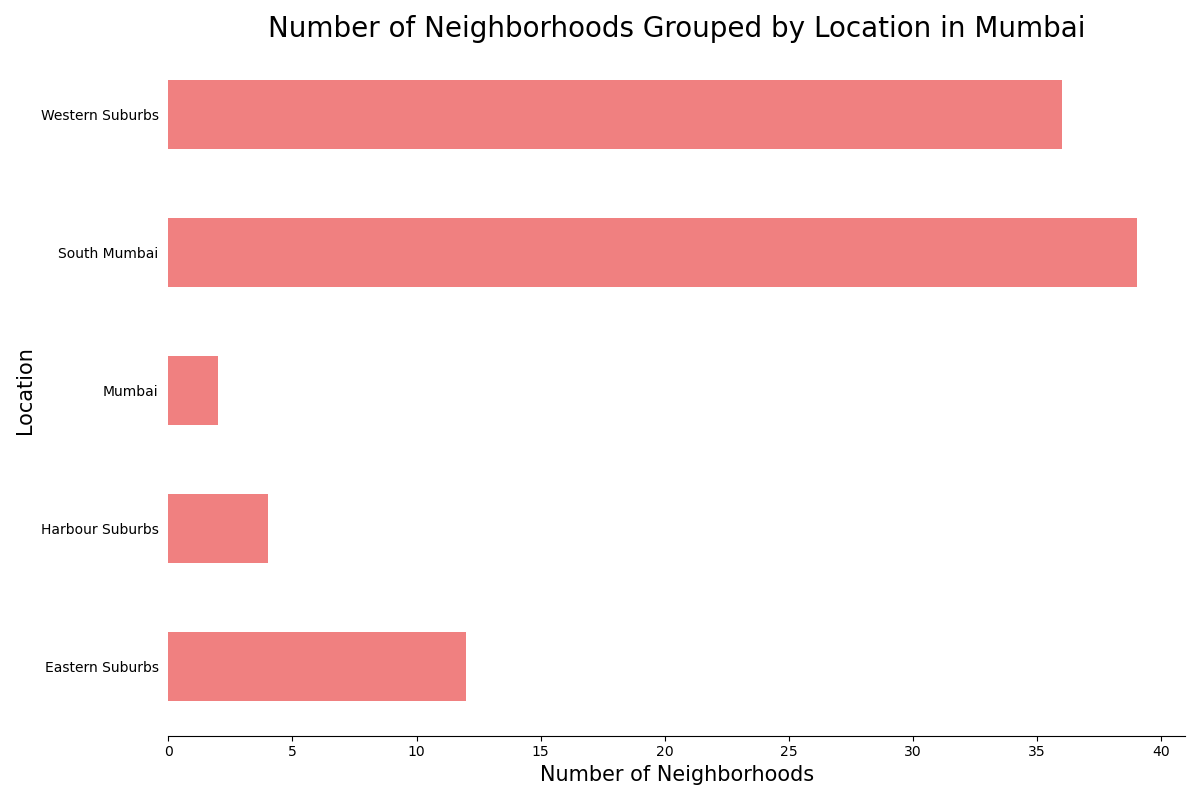

In [54]:
fig = plt.figure(figsize=(12,8))

ax = neighborhoods_mumbai.plot(kind='barh', color='lightcoral')
ax.set_title('Number of Neighborhoods Grouped by Location in Mumbai', fontsize=20)
ax.set_xlabel('Number of Neighborhoods', fontsize=15)
ax.set_ylabel('Location', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(which='major', left=False)

fig.tight_layout()

Clearly we can see that South Mumbai and Western Suburbs have the most number of neighborhoods. Notice how we see one of the locations as Mumbai itself? This is because the neighborhoods contained in this location are located at the outskirts of Mumbai and thus have been grouped as just Mumbai.

Now lets visualize the neighborhoods on a map using Folium. First we will obtain the geographical coordinates of Mumbai using GeoPy.

In [57]:
map_mum = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(df['Latitude'], df['Longitude'], df['Location'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

### Using Foursquare API

Now we can start working with the Foursquare API to obtain venue recommendations.

In [67]:
neighborhood_name = df.loc[0, 'Neighborhood']
neighborhood_lat = df.loc[0, 'Latitude']
neighborhood_long = df.loc[0, 'Longitude']

print("The neighborhood is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The neighborhood is Amboli and it's geographical coordinates are 19.1293 latitude and 72.84644000000003 longitude


Lets create the Foursquare credentials first.

In [63]:
# define Foursquare Credentials and Version
CLIENT_ID = 'CPW3BYE0AHWLF5PWGTPDWEZEZOQ5GA2KL4DMBUSUW04HQGC2' # your Foursquare ID
CLIENT_SECRET = 'IEQ2HT4AE3AA4P1WQQMGB0HVK15JSI5S333CJUUUL3YCL0SJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CPW3BYE0AHWLF5PWGTPDWEZEZOQ5GA2KL4DMBUSUW04HQGC2
CLIENT_SECRET:IEQ2HT4AE3AA4P1WQQMGB0HVK15JSI5S333CJUUUL3YCL0SJ


We will now extract the top 200 venues near Amboli with a radius of 1000m or 1km. In order to do this, we will start by creating a url.

In [65]:
LIMIT = 200
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

We can now use the GET method to get our results.

In [66]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60bc9d5deadef97baa3ac2e5'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Jogeshwari West',
  'headerFullLocation': 'Jogeshwari West, Mumbai',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 19,
  'suggestedBounds': {'ne': {'lat': 19.13830000900001,
    'lng': 72.85594823590122},
   'sw': {'lat': 19.120299990999992, 'lng': 72.83693176409884}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e4eb3c68877402b06b92160',
       'name': '5 Spice , Bandra',
       'location': {'address': 'Pali Naka, Bandra west',
        'lat': 19.130421080343595,
        'lng': 72.84720633881638,
        'labeledLatLngs': [{'label': 'display',
    

We will now create a function get_category_type to extract the categories of venues.

In [68]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we can clean the JSON obtained using the GET method and store our results in a dataframe.

In [69]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,"5 Spice , Bandra",Chinese Restaurant,19.130421,72.847206
1,Cafe Arfa,Indian Restaurant,19.128930,72.847140
2,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant,19.137714,72.845909
3,Narayan Sandwich,Sandwich Place,19.121398,72.850270
4,Domino's Pizza,Pizza Place,19.131000,72.848000


We can check how many venues were returned by Foursquare.

In [70]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

19 venues were returned for Amboli by Foursquare


### Generalizing Foursquare API

Now that we have seen how the API call works and how we can clean our data to get relevant information, we can generalize this procedure to get nearby venues for all neighborhoods by creating the function getNearbyVenues.

In [71]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We can apply the function created to get nearby venues for all neighborhoods in Mumbai. We will get 200 nearby venues within a 1km radius, same as before.

In [72]:
mum_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius)

Amboli
Chakala, Andheri
D.N. Nagar
Four Bungalows
Lokhandwala
Marol
Sahar
Seven Bungalows
Versova
Mira Road
Bhayandar
Uttan
Bandstand Promenade
Kherwadi
Pali Hill
I.C. Colony
Gorai
Dahisar
Aarey Milk Colony
Bangur Nagar
Jogeshwari West
Juhu
Charkop
Poisar
Mahavir Nagar
Thakur village
Pali Naka
Khar Danda
Dindoshi
Sunder Nagar
Kalina
Naigaon
Nalasopara
Virar
Irla
Vile Parle
Bhandup
Amrut Nagar
Asalfa
Pant Nagar
Kanjurmarg
Nehru Nagar
Nahur
Chandivali
Hiranandani Gardens
Indian Institute of Technology Bombay campus
Vidyavihar
Vikhroli
Chembur
Deonar
Mankhurd
Mahul
Agripada
Altamount Road
Bhuleshwar
Breach Candy
Carmichael Road
Cavel
Churchgate
Cotton Green
Cuffe Parade
Cumbala Hill
Currey Road
Dhobitalao
Dongri
Kala Ghoda
Kemps Corner
Lower Parel
Mahalaxmi
Mahim
Malabar Hill
Marine Drive
Marine Lines
Mumbai Central
Nariman Point
Prabhadevi
Sion
Walkeshwar
Worli
C.G.S. colony
Dagdi Chawl
Navy Nagar
Hindu colony
Ballard Estate
Chira Bazaar
Fanas Wadi
Chor Bazaar
Matunga
Parel
Gowalia Tank


Lets see what our dataframe looks like.

In [73]:
print(mum_venues.shape)
mum_venues.head(10)

(3226, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,19.1293,72.84644,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
1,Amboli,19.1293,72.84644,Cafe Arfa,19.128930,72.847140,Indian Restaurant
2,Amboli,19.1293,72.84644,Jaffer Bhai's Delhi Darbar,19.137714,72.845909,Mughlai Restaurant
3,Amboli,19.1293,72.84644,Narayan Sandwich,19.121398,72.850270,Sandwich Place
4,Amboli,19.1293,72.84644,Domino's Pizza,19.131000,72.848000,Pizza Place
5,Amboli,19.1293,72.84644,Persia Darbar,19.136952,72.846822,Indian Restaurant
6,Amboli,19.1293,72.84644,Garden Court,19.127188,72.837478,Indian Restaurant
7,Amboli,19.1293,72.84644,Subway,19.127860,72.844461,Sandwich Place
8,Amboli,19.1293,72.84644,Courtyard Restaurant & Bar,19.131692,72.837269,Asian Restaurant
9,Amboli,19.1293,72.84644,Kamal Chhaya Bar,19.128245,72.837610,Bar


Lets see how many venues were returned for each neighborhood.

In [74]:
mum_venues.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aarey Milk Colony,13,13,13,13,13,13
1,Agripada,24,24,24,24,24,24
2,Altamount Road,60,60,60,60,60,60
3,Amboli,19,19,19,19,19,19
4,Amrut Nagar,14,14,14,14,14,14
...,...,...,...,...,...,...,...
88,Vikhroli,6,6,6,6,6,6
89,Vile Parle,65,65,65,65,65,65
90,Virar,16,16,16,16,16,16
91,Walkeshwar,13,13,13,13,13,13


We can now check how many unique categories are there in our data.

In [75]:
print("There are {} unique categories".format(mum_venues['Venue Category'].nunique()))

There are 211 unique categories


### Analyzing each neighborhood

We can start analyzing each neighborhood by One-hot Encoding to see which categories belong in which neighborhoods.

In [76]:
mum_onehot = pd.get_dummies(mum_venues[['Venue Category']], prefix="", prefix_sep="")
mum_onehot.head()

,Accessories Store,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Train Station,Vegetarian / Vegan Restaurant,Video Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Adding Neighborhood column to the one-hot encoded dataframe.

In [78]:
mum_onehot['Neighborhood'] = mum_venues['Neighborhood']
mum_onehot.head()

,Accessories Store,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Train Station,Vegetarian / Vegan Restaurant,Video Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Moving the Neighborhood column to the first column.

In [79]:
temp = list(mum_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
mum_onehot = mum_onehot[fixed_columns]

mum_onehot.head()

,Neighborhood,Accessories Store,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Train Station,Vegetarian / Vegan Restaurant,Video Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can groupby neighborhood and take the mean for all categories.

In [80]:
mum_grouped = mum_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(mum_grouped.shape)
mum_grouped.head(10)

(93, 211)


,Neighborhood,Accessories Store,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Train Station,Vegetarian / Vegan Restaurant,Video Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Amboli,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,"Chakala, Andheri",0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.064516,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,D.N. Nagar,0.024390,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.048780,0.000000,0.0,0.0,0.0,0.000000,0.048780,0.0,0.0
3,Four Bungalows,0.019608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.039216,0.000000,0.0,0.0,0.0,0.000000,0.019608,0.0,0.0
4,Lokhandwala,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.012048,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
5,Marol,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
6,Sahar,0.000000,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.041667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
7,Seven Bungalows,0.019231,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.038462,0.000000,0.0,0.0,0.0,0.000000,0.019231,0.0,0.0
8,Versova,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.029412,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.029412,0.000000,0.0,0.0
9,Mira Road,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In order to further understand the data, we can display the top 5 venues of all neighborhoods.

In [81]:
num_top_venues = 5

for hood in mum_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mum_grouped[mum_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amboli----
                venue  freq
0   Indian Restaurant  0.16
1         Pizza Place  0.11
2                 Bar  0.11
3      Sandwich Place  0.11
4  Mughlai Restaurant  0.05


----Chakala, Andheri----
               venue  freq
0              Hotel  0.19
1  Indian Restaurant  0.13
2               Café  0.10
3          Hotel Bar  0.06
4         Restaurant  0.06


----D.N. Nagar----
               venue  freq
0                Pub  0.10
1  Indian Restaurant  0.10
2                Bar  0.10
3        Pizza Place  0.07
4      Women's Store  0.05


----Four Bungalows----
                venue  freq
0                 Pub  0.08
1   Indian Restaurant  0.06
2  Chinese Restaurant  0.06
3              Lounge  0.06
4  Seafood Restaurant  0.06


----Lokhandwala----
                venue  freq
0   Indian Restaurant  0.13
1                Café  0.10
2         Coffee Shop  0.06
3  Chinese Restaurant  0.06
4                 Bar  0.04


----Marol----
                venue  freq
0   Indian Restaur

Lets now create a dataframe with the top 10 common venues for each neighborhood.

In [82]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [83]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_grouped['Neighborhood']

for ind in np.arange(mum_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Indian Restaurant,Pizza Place,Sandwich Place,Bar,Bakery,Athletics & Sports,Metro Station,Burger Joint,Bike Rental / Bike Share,Mughlai Restaurant
1,"Chakala, Andheri",Hotel,Indian Restaurant,Café,Hotel Bar,Asian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Restaurant,Burger Joint,Multiplex
2,D.N. Nagar,Pub,Bar,Indian Restaurant,Pizza Place,Gym / Fitness Center,Women's Store,Vegetarian / Vegan Restaurant,Juice Bar,Snack Place,Hotel Bar
3,Four Bungalows,Pub,Lounge,Chinese Restaurant,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Café,Coffee Shop,Ice Cream Shop
4,Lokhandwala,Indian Restaurant,Café,Coffee Shop,Chinese Restaurant,Bar,Pub,Italian Restaurant,Fast Food Restaurant,Asian Restaurant,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
88,Parel,Coffee Shop,Playground,Indian Restaurant,Chinese Restaurant,Plaza,Restaurant,Rest Area,Maharashtrian Restaurant,Bar,Vegetarian / Vegan Restaurant
89,Gowalia Tank,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Bakery,Electronics Store,Café,Sandwich Place,Vegetarian / Vegan Restaurant,Snack Place,Ice Cream Shop
90,Dava Bazaar,Train Station,Indian Restaurant,Fish Market,Hotel,French Restaurant,Fast Food Restaurant,Café,Coffee Shop,Clothing Store,Asian Restaurant
91,Dharavi,Indian Restaurant,Paper / Office Supplies Store,Café,Fast Food Restaurant,Shoe Store,Seafood Restaurant,Sandwich Place,Luggage Store,Diner,Bus Station


### Clustering neighborhoods

Now we can use KMeans clustering method to cluster the neighborhoods.

First we need to determine how many clusters to use. This will be done using the Silhouette Score.

We will define a function to plot the Silhouette Score that will be calculated using different number of clusters.

In [84]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [85]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = mum_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

We can now display the scores for different number of clusters and plot the data as well.



[0.08425759881081543, 0.07233386168138874, 0.09959652264105467, 0.10314405919995216, 0.09425217482251408, 0.07612589145938138, 0.09538687477102502, 0.0800537953955948, 0.05391988345484384, 0.06749490096218372, 0.06969417850600652, 0.07875623320675133, 0.06794761153577333, 0.07266185548601563]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


<IPython.core.display.Javascript object>


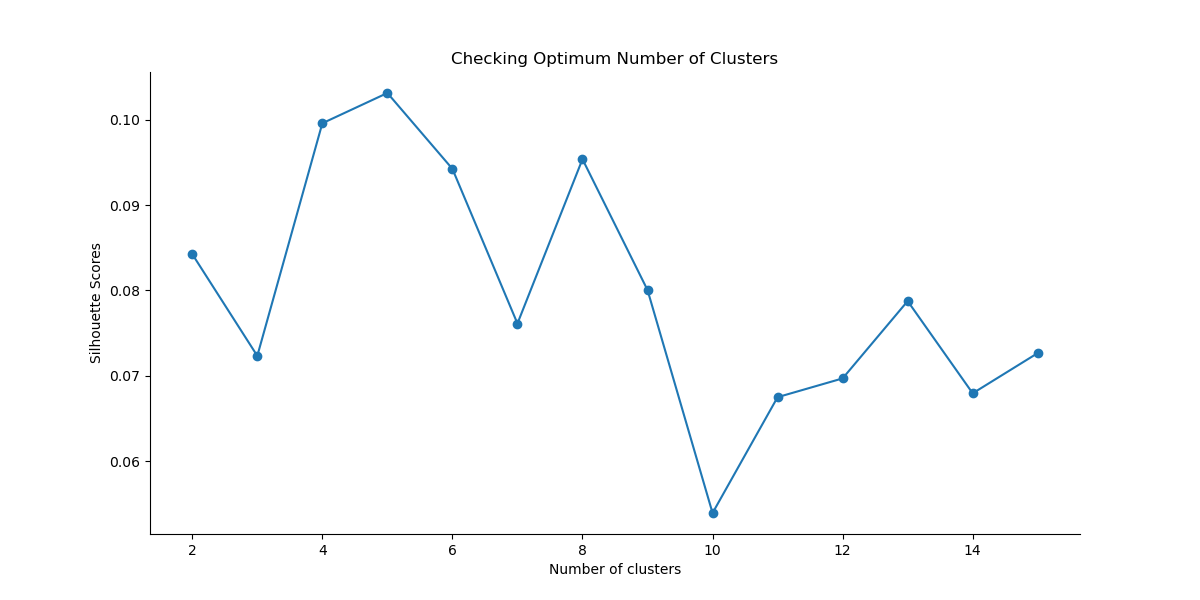

In [86]:
print(scores)
print(kval)
plot(kval, scores)

We can see that the silhouette scores are not very high even as we increase the number of clusters. This means that the inter-cluster distance between different clusters is not very high over the range of k-values. However, we will try to cluster our data as best as we can. For this, we will use 5 clusters for our clustering model since it provides the highest silhouette score as seen above.

In [87]:
k = 5

mum_clustering = mum_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(mum_clustering) #Can choose any random_state

kmeans.labels_

array([1, 0, 1, 1, 1, 3, 0, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 0, 1, 1, 3,
       1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 4, 1, 1, 1, 3, 3, 1,
       1, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3,
       1, 1, 1, 1, 2], dtype=int32)

Now we can create a new dataframe that includes cluster labels and the top 10 venues.



In [88]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
mum_merged = df
mum_merged = mum_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Lets view the newly created dataframe.



In [89]:
print(mum_merged.shape)
mum_merged

(93, 15)


,Neighborhood,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,19.1293,72.8464,1,Indian Restaurant,Pizza Place,Sandwich Place,Bar,Bakery,Athletics & Sports,Metro Station,Burger Joint,Bike Rental / Bike Share,Mughlai Restaurant
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,0,Hotel,Indian Restaurant,Café,Hotel Bar,Asian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Restaurant,Burger Joint,Multiplex
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,1,Pub,Bar,Indian Restaurant,Pizza Place,Gym / Fitness Center,Women's Store,Vegetarian / Vegan Restaurant,Juice Bar,Snack Place,Hotel Bar
3,Four Bungalows,Western Suburbs,19.1264,72.8242,1,Pub,Lounge,Chinese Restaurant,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Café,Coffee Shop,Ice Cream Shop
4,Lokhandwala,Western Suburbs,19.1432,72.8249,1,Indian Restaurant,Café,Coffee Shop,Chinese Restaurant,Bar,Pub,Italian Restaurant,Fast Food Restaurant,Asian Restaurant,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Parel,South Mumbai,18.9957,72.84,1,Coffee Shop,Playground,Indian Restaurant,Chinese Restaurant,Plaza,Restaurant,Rest Area,Maharashtrian Restaurant,Bar,Vegetarian / Vegan Restaurant
89,Gowalia Tank,South Mumbai,18.9645,72.8112,1,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Bakery,Electronics Store,Café,Sandwich Place,Vegetarian / Vegan Restaurant,Snack Place,Ice Cream Shop
90,Dava Bazaar,South Mumbai,19.1314,72.927,1,Train Station,Indian Restaurant,Fish Market,Hotel,French Restaurant,Fast Food Restaurant,Café,Coffee Shop,Clothing Store,Asian Restaurant
91,Dharavi,Mumbai,19.0467,72.8546,1,Indian Restaurant,Paper / Office Supplies Store,Café,Fast Food Restaurant,Shoe Store,Seafood Restaurant,Sandwich Place,Luggage Store,Diner,Bus Station


We can now view the neighborhoods in each cluster and their top 10 most common venues.



### Cluster 1

In [90]:
mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]


,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Chakala, Andheri",Western Suburbs,Hotel,Indian Restaurant,Café,Hotel Bar,Asian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Restaurant,Burger Joint,Multiplex
6,Sahar,Western Suburbs,Hotel,Indian Restaurant,Restaurant,Gym,Asian Restaurant,Bar,Coffee Shop,Café,Italian Restaurant,Pub
27,Khar Danda,Western Suburbs,Hotel,Clothing Store,Park,Coffee Shop,Dessert Shop,Bookstore,Bistro,French Restaurant,Boutique,Pool
40,Kanjurmarg,Eastern Suburbs,Train Station,Gym,Hotel,Gift Shop,Chinese Restaurant,French Restaurant,Asian Restaurant,Multiplex,Donut Shop,Electronics Store
70,Malabar Hill,South Mumbai,Gym,Hotel,Park,Convenience Store,Lighthouse,Coffee Shop,Dessert Shop,Indian Restaurant,Cupcake Shop,Cosmetics Shop
77,Walkeshwar,South Mumbai,Gym,Park,Hotel,Convenience Store,Food & Drink Shop,Food Truck,Lighthouse,Restaurant,Dessert Shop,Coffee Shop


### Cluster 2

In [91]:
mum_merged.loc[mum_merged['Cluster Labels'] == 1, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]


,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,Indian Restaurant,Pizza Place,Sandwich Place,Bar,Bakery,Athletics & Sports,Metro Station,Burger Joint,Bike Rental / Bike Share,Mughlai Restaurant
2,D.N. Nagar,Western Suburbs,Pub,Bar,Indian Restaurant,Pizza Place,Gym / Fitness Center,Women's Store,Vegetarian / Vegan Restaurant,Juice Bar,Snack Place,Hotel Bar
3,Four Bungalows,Western Suburbs,Pub,Lounge,Chinese Restaurant,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Café,Coffee Shop,Ice Cream Shop
4,Lokhandwala,Western Suburbs,Indian Restaurant,Café,Coffee Shop,Chinese Restaurant,Bar,Pub,Italian Restaurant,Fast Food Restaurant,Asian Restaurant,Seafood Restaurant
7,Seven Bungalows,Western Suburbs,Café,Pub,Bar,Chinese Restaurant,Indian Restaurant,Seafood Restaurant,Pizza Place,Ice Cream Shop,Vegetarian / Vegan Restaurant,Coffee Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
83,Ballard Estate,South Mumbai,Indian Restaurant,Café,Coffee Shop,Seafood Restaurant,Bar,Parsi Restaurant,Lounge,Train Station,Irani Cafe,Dessert Shop
88,Parel,South Mumbai,Coffee Shop,Playground,Indian Restaurant,Chinese Restaurant,Plaza,Restaurant,Rest Area,Maharashtrian Restaurant,Bar,Vegetarian / Vegan Restaurant
89,Gowalia Tank,South Mumbai,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Bakery,Electronics Store,Café,Sandwich Place,Vegetarian / Vegan Restaurant,Snack Place,Ice Cream Shop
90,Dava Bazaar,South Mumbai,Train Station,Indian Restaurant,Fish Market,Hotel,French Restaurant,Fast Food Restaurant,Café,Coffee Shop,Clothing Store,Asian Restaurant


### Cluster 3

In [92]:
mum_merged.loc[mum_merged['Cluster Labels'] == 2, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]


,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
92,Thane,Mumbai,Platform,Pizza Place,Performing Arts Venue,Dessert Shop,Fish & Chips Shop,Field,Fast Food Restaurant,Falafel Restaurant,Event Space,Electronics Store


### Cluster 4

In [93]:
mum_merged.loc[mum_merged['Cluster Labels'] == 3, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]


,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Marol,Western Suburbs,Indian Restaurant,Chinese Restaurant,Hotel,Coffee Shop,Bakery,Restaurant,Lounge,Department Store,Dance Studio,Diner
9,Mira Road,Western Suburbs,Indian Restaurant,Mexican Restaurant,Bar,Coffee Shop,Fast Food Restaurant,Movie Theater,Basketball Court,Convenience Store,Gym / Fitness Center,Dhaba
11,Uttan,Western Suburbs,Convenience Store,Indian Restaurant,Whisky Bar,Restaurant,Zoo,Dhaba,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
20,Jogeshwari West,Western Suburbs,Indian Restaurant,Restaurant,Gym,Café,Business Service,Bus Station,Men's Store,Mughlai Restaurant,Ice Cream Shop,Chinese Restaurant
36,Bhandup,Eastern Suburbs,Train Station,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Zoo,Dim Sum Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Field
37,Amrut Nagar,Eastern Suburbs,Indian Restaurant,Ice Cream Shop,Pharmacy,Train Station,Café,Multiplex,Bus Station,Mughlai Restaurant,Restaurant,Plaza
39,Pant Nagar,Eastern Suburbs,Indian Restaurant,Coffee Shop,Shopping Mall,Café,Vegetarian / Vegan Restaurant,Bakery,Platform,Fast Food Restaurant,Bus Station,Diner
43,Chandivali,Eastern Suburbs,Indian Restaurant,Fast Food Restaurant,Restaurant,Seafood Restaurant,Brewery,Café,Food,Lounge,Chinese Restaurant,Pub
46,Vidyavihar,Eastern Suburbs,Indian Restaurant,Fast Food Restaurant,Juice Bar,Playground,Chinese Restaurant,Dessert Shop,Ice Cream Shop,Vegetarian / Vegan Restaurant,Train Station,Bar
48,Chembur,Harbour Suburbs,Indian Restaurant,Pizza Place,Café,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Asian Restaurant,Bar,Seafood Restaurant,Garden


### Cluster 5

In [94]:
mum_merged.loc[mum_merged['Cluster Labels'] == 4, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]


,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,Cotton Green,South Mumbai,Plaza,Pizza Place,Fast Food Restaurant,Train Station,Bakery,Dhaba,Fish Market,Fish & Chips Shop,Field,Falafel Restaurant


Comparing clusters 1 and 2, neighborhoods in cluster 1 seem to be more suited for starting a restaurant since they contains a larger percentage of food joints in the top 10 most common venues than cluster 2. The neighborhoods in cluster 1 contain a variety of food joints like restaurants, tea rooms, bakery, cafe, steakhouse and pubs and also contain very diverse cuisines like Japanese, Indian, Chinese, Italian and seafood restaurants. Most neighborhoods in cluster 2 seem to have Indian Restaurant as their top most common venue; however, on careful analysis we can see that neighborhoods in cluster 2 also contain other venues like soccer field, flea market, smoke shop, gym, train station, dance studio, music store, cosmetics shop and so on. Thus, it is recommended that the new restaurant can be opened in the neighborhoods belonging to cluster 1. This neighborhood can be further plotted on a map as shown below.

In [95]:
new_restaurant_neighborhoods = mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0, 1, 2, 3] + list(range(5, mum_merged.shape[1]))]]
new_restaurant_neighborhoods.head()

,Neighborhood,Location,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,Hotel,Indian Restaurant,Café,Hotel Bar,Asian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Restaurant,Burger Joint,Multiplex
6,Sahar,Western Suburbs,19.1027,72.8626,Hotel,Indian Restaurant,Restaurant,Gym,Asian Restaurant,Bar,Coffee Shop,Café,Italian Restaurant,Pub
27,Khar Danda,Western Suburbs,19.0843,72.8269,Hotel,Clothing Store,Park,Coffee Shop,Dessert Shop,Bookstore,Bistro,French Restaurant,Boutique,Pool
40,Kanjurmarg,Eastern Suburbs,19.1314,72.9357,Train Station,Gym,Hotel,Gift Shop,Chinese Restaurant,French Restaurant,Asian Restaurant,Multiplex,Donut Shop,Electronics Store
70,Malabar Hill,South Mumbai,18.95,72.795,Gym,Hotel,Park,Convenience Store,Lighthouse,Coffee Shop,Dessert Shop,Indian Restaurant,Cupcake Shop,Cosmetics Shop


In [96]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(new_restaurant_neighborhoods['Latitude'], new_restaurant_neighborhoods['Longitude'],
                                            new_restaurant_neighborhoods['Location'], new_restaurant_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations